In [1]:
!pip install torchtext==0.4.0
!pip install subword_nmt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 381.9 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [2]:
import sys
sys.path.insert(1, "../input/mymodels")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from train_model import train
from get_score import get_results

In [4]:
# getting data
path_to_data = '../input/mydata/data.txt'
from data_preprocessing import get_dataset


data, vocab = get_dataset(path_to_data)
train_data, valid_data, test_data = data
src_vocab, trg_vocab = vocab
PAD_IDX = trg_vocab.stoi['<pad>']


def _len_sort_key(x):
    return len(x.src)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_iterators(train_data=train_data, 
                  valid_data=valid_data,
                  test_data=test_data,
                  batch_size=512):


    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = batch_size, 
        device = device,
        sort_key=_len_sort_key
    )
    return train_iterator, valid_iterator, test_iterator

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9266
Unique tokens in target (en) vocabulary: 6720


In [5]:
import base_line_model
train_iterator, val_iterator, test_iterator = get_iterators()
baseline = base_line_model.get_model(len(src_vocab), len(trg_vocab))

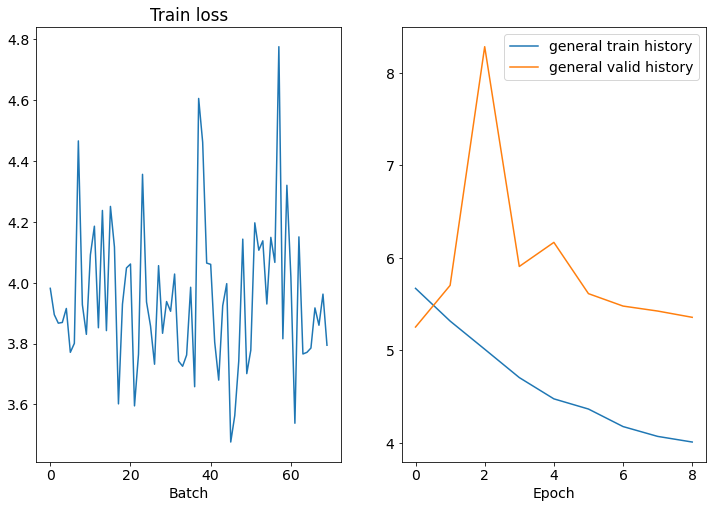

Epoch: 10 | Time: 1m 36s
	Train Loss: 3.960 | Train PPL:  52.441
	 Val. Loss: 5.238 |  Val. PPL: 188.257
CPU times: user 10min 52s, sys: 5min 20s, total: 16min 12s
Wall time: 16min 7s


In [6]:
%%time
optimizer = optim.Adam(baseline.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, 
                              patience=2, min_lr=1e-6, verbose=True)
train(baseline, "baseline", train_iterator, 
     val_iterator, optimizer, scheduler, criterion, n_epochs = 10)

In [7]:
get_results(baseline, test_iterator, trg_vocab)

The model has 14,896,192 trainable parameters


15it [00:06,  2.38it/s]


BLEU score: 2.675455324558731

Successful examples of translation:

	 Original: the air - conditioned unit is 500 metres from .
	 Generated: is a 10 - minute walk from the property .

	 Original: station is within a walking distance .
	 Generated: is a metres from the property .

	 Original: free wifi is offered .
	 Generated: suite parking is available .

Bad translation examples: 

	 Original: coffee is available for guests 24 hours a day at this pet - friendly motel .
	 Generated: .

	 Original: in the surrounding area , guests may easily find a variety of local eateries .
	 Generated: .

	 Original: the cross - country ski run and the cycling trails are close by .
	 Generated: .



In [11]:
import seq_to_seq_with_Attention_LSTM

train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=128)
ss_attent_lstm = seq_to_seq_with_Attention_LSTM.get_model(len(src_vocab), len(trg_vocab))

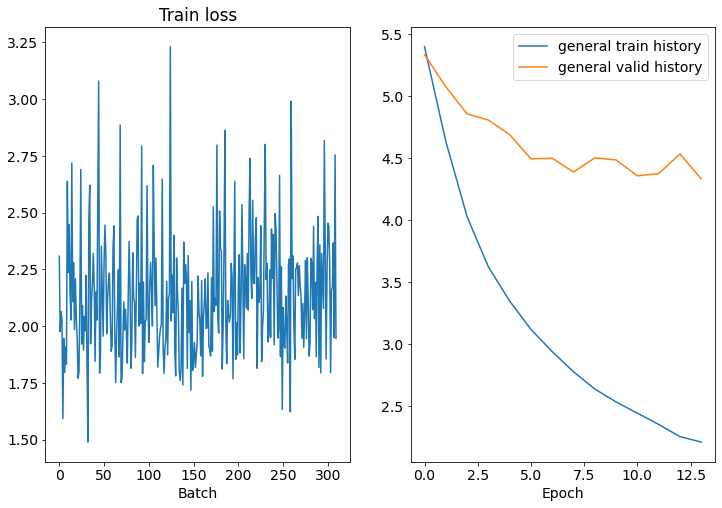

Epoch: 15 | Time: 2m 6s
	Train Loss: 2.133 | Train PPL:   8.442
	 Val. Loss: 4.407 |  Val. PPL:  82.060
CPU times: user 24min 41s, sys: 7min 32s, total: 32min 13s
Wall time: 31min 22s


In [12]:
%%time
optimizer = optim.Adam(ss_attent_lstm.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-6, verbose=True)

train(ss_attent_lstm, "seq_to_seq_Attention_LSTM", train_iterator, 
     valid_iterator, optimizer, scheduler, criterion, n_epochs = 15)

In [13]:
get_results(ss_attent_lstm, test_iterator, trg_vocab)

The model has 19,123,264 trainable parameters


59it [00:06,  8.62it/s]


BLEU score: 27.738535271927834

Successful examples of translation:

	 Original: some rooms have a seating area .
	 Generated: some rooms have a seating area .

	 Original: a continental breakfast is served daily .
	 Generated: a continental breakfast is served daily .

	 Original: the bathroom comes with a shower .
	 Generated: the bathroom comes with a shower .

Bad translation examples: 

	 Original: guests can also have a traditional meal , composed of organic products upon request .
	 Generated: breakfast breakfast are available on request .

	 Original: electric kettle is also provided . the attached bathroom comes with shower facility .
	 Generated: the bathroom comes with a shower .

	 Original: it has a 24 - hour reception .
	 Generated: there is a 24 - hour front desk at the property .



In [20]:
import seq_to_seq_with_Attention_gru

train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=128)
ss_attent_gru = seq_to_seq_with_Attention_gru.get_model(len(src_vocab), len(trg_vocab))

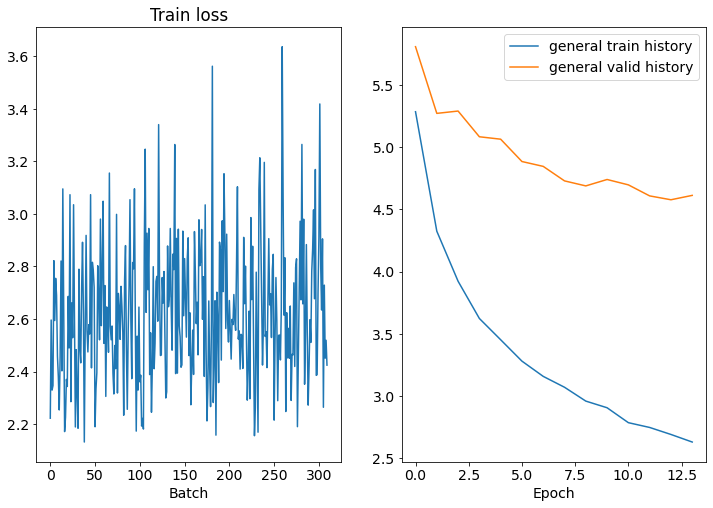

Epoch: 15 | Time: 2m 35s
	Train Loss: 2.622 | Train PPL:  13.765
	 Val. Loss: 4.622 |  Val. PPL: 101.674
CPU times: user 28min 53s, sys: 10min 33s, total: 39min 26s
Wall time: 38min 40s


In [21]:
%%time
optimizer = optim.Adam(ss_attent_gru.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-6, verbose=True)

train(ss_attent_gru, "seq_to_seq_Attention_GRU", train_iterator, 
     valid_iterator, optimizer, scheduler, criterion, n_epochs = 15)

In [23]:
from get_score_ import get_results_

In [24]:
get_results_(ss_attent_gru, test_iterator, trg_vocab)

The model has 15,839,808 trainable parameters


59it [00:07,  7.85it/s]


BLEU score: 18.542956844993892

Successful examples of translation:

	 Original: free private parking is available on site .
	 Generated: free private parking is available on site .

	 Original: free private parking is available on site .
	 Generated: free private parking is available on site .

	 Original: beach is just 500 metres away .
	 Generated: the beach is just 500 metres away .

Bad translation examples: 

	 Original: alternatively , there are also many restaurants located within walking distance of the hotel .
	 Generated: restaurants can be found within walking distance .

	 Original: you will find a tv and a kettle in each room .
	 Generated: all rooms come with a tv and a private bathroom with a hairdryer .

	 Original: they all include a flat - screen tv while some include access to the executive lounge .
	 Generated: some rooms have a spa bath .

